In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

url = (
    "http://biostat.mc.vanderbilt.edu/"
    "wiki/pub/Main/DataSets/titanic3.xls"
)
df = pd.read_excel(url)
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])


pclass        False
age           False
sibsp         False
parch         False
fare          False
sex_male      False
embarked_Q    False
embarked_S    False
dtype: bool


In [7]:
from sklearn.linear_model import (
    LogisticRegression,
)
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)
lr.predict(X.iloc[[0]])
lr.predict_proba(X.iloc[[0]])
lr.predict_log_proba(X.iloc[[0]])
lr.decision_function(X.iloc[[0]])

/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([-2.16531643])

In [8]:
lr.intercept_

array([1.22466932])

In [9]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
inv_logit(lr.intercept_)

array([0.77288422])

In [12]:
cols = X.columns
for col, val in sorted(
    zip(cols, lr.coef_[0]),
    key=lambda x: x[1],
    reverse=True,
):
    print(
        f"{col:10}{val:10.3f} {inv_logit(val):10.3f}"
    )

fare           0.071      0.518
parch         -0.022      0.495
sibsp         -0.368      0.409
embarked_Q    -0.434      0.393
age           -0.471      0.384
embarked_S    -0.519      0.373
pclass        -0.853      0.299
sex_male      -2.504      0.076


/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


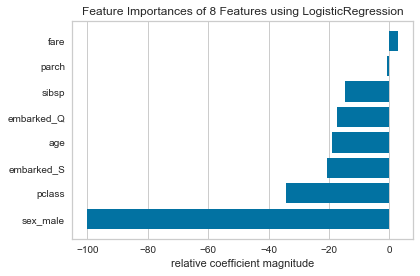

In [13]:
from yellowbrick.features.importances import (
    FeatureImportances,
)
fig, ax = plt.subplots(figsize=(6, 4))
fi_viz = FeatureImportances(lr)
fi_viz.fit(X, y)
fi_viz.poof()
#fig.savefig("images/mlpr_1001.png", dpi=300)

In [14]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)
nb.predict(X.iloc[[0]])
nb.predict_proba(X.iloc[[0]])
nb.predict_log_proba(X.iloc[[0]])

array([[-0.04128744, -3.20776959]])

In [15]:
from sklearn.svm import SVC
svc = SVC(random_state=42, probability=True)
svc.fit(X_train, y_train)
svc.score(X_test, y_test)
svc.predict(X.iloc[[0]])
svc.predict_proba(X.iloc[[0]])
svc.predict_log_proba(X.iloc[[0]])

/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([[-0.16027309, -1.90994258]])

In [16]:
from sklearn.neighbors import (
    KNeighborsClassifier,
)
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
knc.score(X_test, y_test)
knc.predict(X.iloc[[0]])
knc.predict_proba(X.iloc[[0]])

array([[0.8, 0.2]])

In [17]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
    random_state=42, max_depth=3
)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)
dt.predict(X.iloc[[0]])
dt.predict_proba(X.iloc[[0]])
dt.predict_log_proba(X.iloc[[0]])

array([[-0.12835003, -2.11648281]])

In [19]:
import pydotplus
from io import StringIO
from sklearn.tree import export_graphviz
dot_data = StringIO()
tree.export_graphviz(
    dt,
    out_file=dot_data,
    feature_names=X.columns,
    class_names=["Died", "Survived"],
    filled=True,
)
g = pydotplus.graph_from_dot_data(
    dot_data.getvalue()
)
#g.write_png("images/mlpr_1002.png")

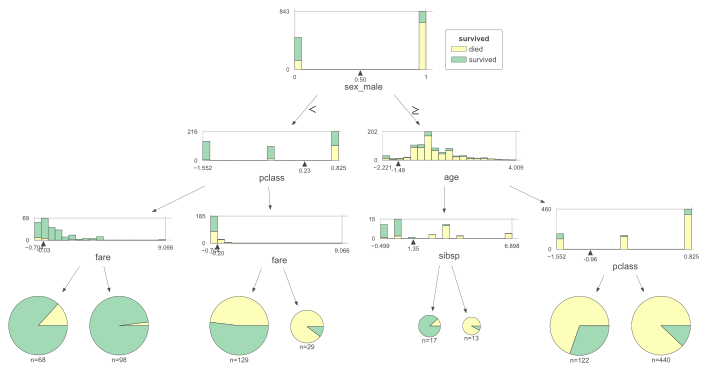

In [28]:
import dtreeviz.trees
viz = dtreeviz.trees.dtreeviz(
    dt,
    X,
    y,
    target_name="survived",
    feature_names=X.columns,
    class_names=["died", "survived"],
)
viz

In [29]:
for col, val in sorted(
    zip(X.columns, dt.feature_importances_),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

sex_male       0.607
pclass         0.248
sibsp          0.052
fare           0.050
age            0.043


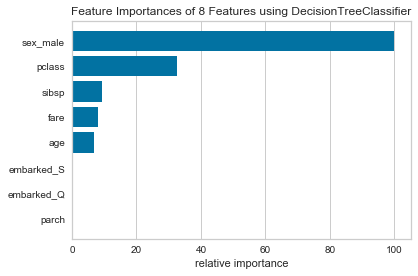

In [30]:
from yellowbrick.features.importances import (
    FeatureImportances,
)
fig, ax = plt.subplots(figsize=(6, 4))
fi_viz = FeatureImportances(dt)
fi_viz.fit(X, y)
fi_viz.poof()
#fig.savefig("images/mlpr_1004.png", dpi=300)

In [31]:
from sklearn.ensemble import (
    RandomForestClassifier,
)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)
rf.predict(X.iloc[[0]])
rf.predict_proba(X.iloc[[0]])
rf.predict_log_proba(X.iloc[[0]])

/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/forest.py:635: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


array([[  0., -inf]])

In [32]:
for col, val in sorted(
    zip(X.columns, rf.feature_importances_),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

age            0.280
fare           0.274
sex_male       0.230
pclass         0.086
sibsp          0.053


In [33]:
import rfpimp
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rfpimp.importances(
    rf, X_test, y_test
).Importance

/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Feature
sex_male      0.155216
fare          0.040712
pclass        0.033079
embarked_Q    0.010178
age           0.007634
parch         0.005089
embarked_S   -0.002545
sibsp        -0.007634
Name: Importance, dtype: float64

In [34]:
import xgboost as xgb
xgb_class = xgb.XGBClassifier(random_state=42)
xgb_class.fit(
    X_train,
    y_train,
    early_stopping_rounds=10,
    eval_set=[(X_test, y_test)],
)
xgb_class.score(X_test, y_test)
xgb_class.predict(X.iloc[[0]])
xgb_class.predict_proba(X.iloc[[0]])

[0]	validation_0-error:0.188295
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.188295
[2]	validation_0-error:0.188295
[3]	validation_0-error:0.188295
[4]	validation_0-error:0.188295
[5]	validation_0-error:0.188295
[6]	validation_0-error:0.203562
[7]	validation_0-error:0.203562
[8]	validation_0-error:0.203562
[9]	validation_0-error:0.203562
[10]	validation_0-error:0.203562
Stopping. Best iteration:
[0]	validation_0-error:0.188295



array([[0.53754187, 0.46245816]], dtype=float32)

In [35]:
for col, val in sorted(
    zip(
        X.columns,
        xgb_class.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

fare           0.293
pclass         0.267
age            0.200
sex_male       0.147
sibsp          0.080


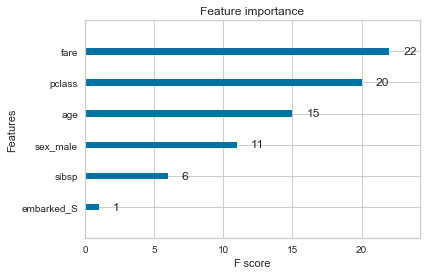

In [36]:
fig, ax = plt.subplots(figsize=(6, 4))
xgb.plot_importance(xgb_class, ax=ax)
#fig.savefig("images/mlpr_1005.png", dpi=300)

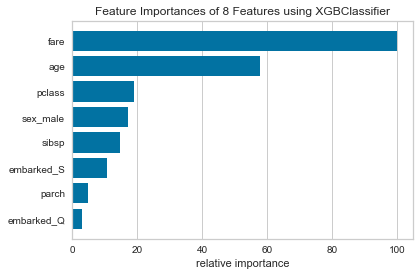

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))
fi_viz = FeatureImportances(xgb_class)
fi_viz.fit(X, y)
fi_viz.poof()
#fig.savefig("images/mlpr_1006.png", dpi=300)

In [38]:
booster = xgb_class.get_booster()
print(booster.get_dump()[0])

0:[sex_male<1] yes=1,no=2,missing=1
	1:[pclass<0.23096557] yes=3,no=4,missing=3
		3:[fare<-0.142878294] yes=7,no=8,missing=7
			7:leaf=0.132530123
			8:leaf=0.184
		4:[fare<-0.195437849] yes=9,no=10,missing=9
			9:leaf=0.0245989319
			10:leaf=-0.145945951
	2:[age<-1.49289274] yes=5,no=6,missing=5
		5:[sibsp<1.81278062] yes=11,no=12,missing=11
			11:leaf=0.135483876
			12:leaf=-0.150000006
		6:[pclass<-0.957598865] yes=13,no=14,missing=13
			13:leaf=-0.0666666701
			14:leaf=-0.148717955



In [39]:
# score from first tree leaf 7
1 / (1 + np.exp(-1 * 0.1238))

0.5309105310475829

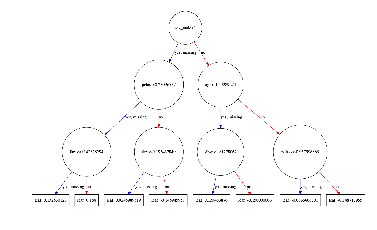

In [40]:
fig, ax = plt.subplots(figsize=(6, 4))
xgb.plot_tree(xgb_class, ax=ax, num_trees=0)
#fig.savefig("images/mlpr_1007.png", dpi=300)

In [41]:
import xgbfir
xgbfir.saveXgbFI(
    xgb_class,
    feature_names=X.columns,
    OutputXlsxFile="fir.xlsx",
)
pd.read_excel("fir.xlsx").head(3).T

,0,1,2
Interaction,sex_male,pclass,fare
Gain,2026.35,743.409,711.231
FScore,48,53,279
wFScore,39.4676,22.203,121.88
Average wFScore,0.822241,0.418924,0.436845
Average Gain,42.2157,14.0266,2.54922
Expected Gain,2016.01,298.442,291.862
Gain Rank,1,2,3
FScore Rank,4,3,1
wFScore Rank,3,4,1


In [42]:
pd.read_excel(
    "fir.xlsx",
    sheet_name="Interaction Depth 1",
).head(2).T

,0,1
Interaction,pclass|sex_male,age|sex_male
Gain,3301.86,1378.75
FScore,38,15
wFScore,15.9816,8.5093
Average wFScore,0.420569,0.567287
Average Gain,86.8911,91.9168
Expected Gain,1375.25,885.229
Gain Rank,1,2
FScore Rank,4,12
wFScore Rank,4,9


In [43]:
pd.read_excel(
    "fir.xlsx",
    sheet_name="Interaction Depth 2",
).head(1).T

,0
Interaction,fare|pclass|sex_male
Gain,4891.87
FScore,44
wFScore,7.8619
Average wFScore,0.178679
Average Gain,111.179
Expected Gain,870.56
Gain Rank,1
FScore Rank,1
wFScore Rank,5


In [44]:
pd.read_excel(
    "fir.xlsx",
    sheet_name="Interaction Depth 2",
)[["Interaction", "Gain"]].head()

,Interaction,Gain
0,fare|pclass|sex_male,4891.867314
1,age|pclass|sex_male,2999.230952
2,age|sex_male|sibsp,1518.797561
3,age|fare|sex_male,334.379201
4,embarked_S|pclass|sex_male,225.302789


In [45]:
import lightgbm as lgb
lgbm_class = lgb.LGBMClassifier(
    random_state=42
)
lgbm_class.fit(X_train, y_train)
lgbm_class.score(X_test, y_test)
lgbm_class.predict(X.iloc[[0]])
lgbm_class.predict_proba(X.iloc[[0]])

/Users/matt/.env/364/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


array([[0.98090161, 0.01909839]])

In [46]:
for col, val in sorted(
    zip(cols, lgbm_class.feature_importances_),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

fare        1285.000
age         1198.000
sex_male     113.000
pclass       112.000
sibsp         99.000


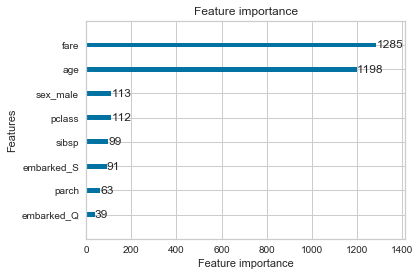

In [47]:
fig, ax = plt.subplots(figsize=(6, 4))
lgb.plot_importance(lgbm_class, ax=ax)
fig.tight_layout()
#fig.savefig("images/mlpr_1008.png", dpi=300)

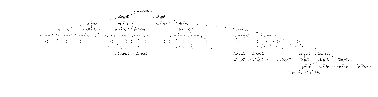

In [48]:
fig, ax = plt.subplots(figsize=(6, 4))
lgb.plot_tree(lgbm_class, tree_index=0, ax=ax)
#fig.savefig("images/mlpr_1009.png", dpi=300)

In [50]:
import janitor as jn
from catboost import CatBoostClassifier
cat_df = df.copy()
cat_df = cat_df.drop(
    [
        "name",
        "ticket",
        "home.dest",
        "boat",
        "body",
        "cabin",
    ],
    axis=1,
)
cat_df = cat_df.fillna(cat_df.median())
cat_df = cat_df.fillna(
    "missing"
)  # for objects
cat_X, cat_y = jn.get_features_targets(
    cat_df, target_columns="survived"
)
X_train3, X_test3, y_train3, y_test3 = model_selection.train_test_split(
    cat_X,
    cat_y,
    test_size=0.3,
    random_state=42,
)
cat_idxs = np.where(cat_X.dtypes == object)[0]
cb = CatBoostClassifier(random_state=42)
cb.fit(
    X_train3,
    y_train3,
    cat_features=cat_idxs,
    plot=True,
)
cb.score(X_test3, y_test3)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6823689	total: 161ms	remaining: 2m 40s
1:	learn: 0.6730914	total: 211ms	remaining: 1m 45s
2:	learn: 0.6632260	total: 262ms	remaining: 1m 26s
3:	learn: 0.6538791	total: 311ms	remaining: 1m 17s
4:	learn: 0.6478152	total: 358ms	remaining: 1m 11s
5:	learn: 0.6416852	total: 408ms	remaining: 1m 7s
6:	learn: 0.6343911	total: 464ms	remaining: 1m 5s
7:	learn: 0.6271106	total: 524ms	remaining: 1m 4s
8:	learn: 0.6207248	total: 531ms	remaining: 58.4s
9:	learn: 0.6138144	total: 544ms	remaining: 53.8s
10:	learn: 0.6079145	total: 555ms	remaining: 49.9s
11:	learn: 0.6015783	total: 569ms	remaining: 46.8s
12:	learn: 0.5961307	total: 577ms	remaining: 43.8s
13:	learn: 0.5908927	total: 588ms	remaining: 41.4s
14:	learn: 0.5856980	total: 595ms	remaining: 39.1s
15:	learn: 0.5800627	total: 614ms	remaining: 37.7s
16:	learn: 0.5754095	total: 632ms	remaining: 36.5s
17:	learn: 0.5702033	total: 646ms	remaining: 35.3s
18:	learn: 0.5654918	total: 658ms	remaining: 34s
19:	learn: 0.5626531	total: 667ms	rema

161:	learn: 0.4183431	total: 4.03s	remaining: 20.8s
162:	learn: 0.4181349	total: 4.04s	remaining: 20.7s
163:	learn: 0.4180694	total: 4.05s	remaining: 20.6s
164:	learn: 0.4177328	total: 4.06s	remaining: 20.5s
165:	learn: 0.4176098	total: 4.07s	remaining: 20.4s
166:	learn: 0.4173431	total: 4.08s	remaining: 20.3s
167:	learn: 0.4171244	total: 4.09s	remaining: 20.2s
168:	learn: 0.4170529	total: 4.09s	remaining: 20.1s
169:	learn: 0.4169032	total: 4.11s	remaining: 20.1s
170:	learn: 0.4166869	total: 4.13s	remaining: 20s
171:	learn: 0.4166315	total: 4.16s	remaining: 20s
172:	learn: 0.4165963	total: 4.2s	remaining: 20.1s
173:	learn: 0.4163431	total: 4.26s	remaining: 20.2s
174:	learn: 0.4159846	total: 4.45s	remaining: 21s
175:	learn: 0.4159282	total: 4.49s	remaining: 21s
176:	learn: 0.4157931	total: 4.53s	remaining: 21.1s
177:	learn: 0.4155947	total: 4.54s	remaining: 21s
178:	learn: 0.4154695	total: 4.55s	remaining: 20.9s
179:	learn: 0.4154385	total: 4.56s	remaining: 20.8s
180:	learn: 0.4152322	t

336:	learn: 0.4008244	total: 7.69s	remaining: 15.1s
337:	learn: 0.4008220	total: 7.71s	remaining: 15.1s
338:	learn: 0.4006772	total: 7.72s	remaining: 15.1s
339:	learn: 0.4006720	total: 7.73s	remaining: 15s
340:	learn: 0.4004785	total: 7.75s	remaining: 15s
341:	learn: 0.4004028	total: 7.76s	remaining: 14.9s
342:	learn: 0.4003743	total: 7.78s	remaining: 14.9s
343:	learn: 0.4003160	total: 7.79s	remaining: 14.9s
344:	learn: 0.4002335	total: 7.84s	remaining: 14.9s
345:	learn: 0.4002100	total: 7.85s	remaining: 14.8s
346:	learn: 0.4001972	total: 7.86s	remaining: 14.8s
347:	learn: 0.4000475	total: 7.87s	remaining: 14.8s
348:	learn: 0.3999706	total: 7.88s	remaining: 14.7s
349:	learn: 0.3997671	total: 7.91s	remaining: 14.7s
350:	learn: 0.3995159	total: 7.92s	remaining: 14.6s
351:	learn: 0.3994287	total: 7.93s	remaining: 14.6s
352:	learn: 0.3994286	total: 7.94s	remaining: 14.6s
353:	learn: 0.3993771	total: 7.96s	remaining: 14.5s
354:	learn: 0.3993734	total: 7.97s	remaining: 14.5s
355:	learn: 0.39

504:	learn: 0.3875526	total: 10.3s	remaining: 10.1s
505:	learn: 0.3874049	total: 10.3s	remaining: 10.1s
506:	learn: 0.3873364	total: 10.4s	remaining: 10.1s
507:	learn: 0.3873346	total: 10.4s	remaining: 10.1s
508:	learn: 0.3870775	total: 10.4s	remaining: 10s
509:	learn: 0.3870092	total: 10.4s	remaining: 10s
510:	learn: 0.3870092	total: 10.4s	remaining: 9.99s
511:	learn: 0.3868806	total: 10.5s	remaining: 9.97s
512:	learn: 0.3867498	total: 10.5s	remaining: 9.95s
513:	learn: 0.3865422	total: 10.5s	remaining: 9.93s
514:	learn: 0.3864644	total: 10.5s	remaining: 9.9s
515:	learn: 0.3864641	total: 10.5s	remaining: 9.87s
516:	learn: 0.3864555	total: 10.5s	remaining: 9.85s
517:	learn: 0.3863899	total: 10.6s	remaining: 9.82s
518:	learn: 0.3860822	total: 10.6s	remaining: 9.79s
519:	learn: 0.3860680	total: 10.6s	remaining: 9.77s
520:	learn: 0.3860063	total: 10.6s	remaining: 9.74s
521:	learn: 0.3859892	total: 10.6s	remaining: 9.71s
522:	learn: 0.3859727	total: 10.6s	remaining: 9.68s
523:	learn: 0.385

679:	learn: 0.3708233	total: 13.2s	remaining: 6.21s
680:	learn: 0.3708156	total: 13.2s	remaining: 6.18s
681:	learn: 0.3708056	total: 13.3s	remaining: 6.19s
682:	learn: 0.3707793	total: 13.3s	remaining: 6.17s
683:	learn: 0.3707403	total: 13.3s	remaining: 6.15s
684:	learn: 0.3706463	total: 13.3s	remaining: 6.13s
685:	learn: 0.3704575	total: 13.3s	remaining: 6.11s
686:	learn: 0.3704484	total: 13.3s	remaining: 6.08s
687:	learn: 0.3704371	total: 13.4s	remaining: 6.06s
688:	learn: 0.3701827	total: 13.4s	remaining: 6.03s
689:	learn: 0.3701752	total: 13.4s	remaining: 6.01s
690:	learn: 0.3701376	total: 13.4s	remaining: 5.99s
691:	learn: 0.3701265	total: 13.4s	remaining: 5.97s
692:	learn: 0.3699993	total: 13.4s	remaining: 5.95s
693:	learn: 0.3699979	total: 13.4s	remaining: 5.92s
694:	learn: 0.3696466	total: 13.4s	remaining: 5.9s
695:	learn: 0.3696134	total: 13.5s	remaining: 5.88s
696:	learn: 0.3695894	total: 13.5s	remaining: 5.85s
697:	learn: 0.3695891	total: 13.5s	remaining: 5.83s
698:	learn: 0

853:	learn: 0.3569514	total: 15.6s	remaining: 2.67s
854:	learn: 0.3569471	total: 15.7s	remaining: 2.66s
855:	learn: 0.3568298	total: 15.7s	remaining: 2.64s
856:	learn: 0.3567887	total: 15.7s	remaining: 2.62s
857:	learn: 0.3567803	total: 15.7s	remaining: 2.6s
858:	learn: 0.3564972	total: 15.7s	remaining: 2.58s
859:	learn: 0.3564409	total: 15.8s	remaining: 2.56s
860:	learn: 0.3562802	total: 15.8s	remaining: 2.55s
861:	learn: 0.3562646	total: 15.8s	remaining: 2.53s
862:	learn: 0.3561903	total: 15.8s	remaining: 2.51s
863:	learn: 0.3561638	total: 15.8s	remaining: 2.49s
864:	learn: 0.3560997	total: 15.8s	remaining: 2.47s
865:	learn: 0.3560595	total: 15.8s	remaining: 2.45s
866:	learn: 0.3559920	total: 15.9s	remaining: 2.43s
867:	learn: 0.3559875	total: 15.9s	remaining: 2.41s
868:	learn: 0.3558697	total: 15.9s	remaining: 2.39s
869:	learn: 0.3555998	total: 15.9s	remaining: 2.38s
870:	learn: 0.3554112	total: 15.9s	remaining: 2.35s
871:	learn: 0.3553287	total: 15.9s	remaining: 2.34s
872:	learn: 0

0.8040712468193384

In [51]:
for col, val in sorted(
    zip(
        X_test3.columns,
        cb.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

sex           40.755
fare          18.512
pclass        15.314
age           13.958
embarked       5.151


In [52]:
from autosklearn.classification import (
    AutoSklearnClassifier,
)
asc = AutoSklearnClassifier(
    time_left_for_this_task=240
)
asc.fit(X_train, y_train)
asc.score(X_test, y_test)
asc.predict(X.iloc[[0]])
asc.predict_proba(X.iloc[[0]])

/Users/matt/.env/364/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-09-03 11:40:52,867:EnsembleBuilder(1):0a993356a7bdc82d24d18a8f291d48dc] Error loading /var/folders/n4/k0dsdvqd7rs5gb90cpvb7ggw0000gn/T/autosklearn_tmp_75166_5860/.auto-sklearn/predictions_ensemble/predictions_ensemble_1_1.npy: Traceback (most recent call last):
  File "/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/ensemble_builder.py", line 316, in read_ensemble_preds
    y_ensemble = self._read_np_fn(fp=fp)
  File "/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/ensemble_builder.py", line 645, in _read_np_fn
    predictions = np.load(fp)
  File "/Users/matt/.env/364/lib/python3.6/site-packages/numpy/lib/npyio.py", line 451, in load
    raise ValueError("Cannot load file containing pickled data "
ValueError: Cannot load file containing pickled data when allow_pickle=False

[WARNING] [2019-09-03 11:40:52,888:EnsembleBuilder(1):0a993356a7bdc82d24d18a8f291d48dc] No models better than random - using Dummy Score!


Process pynisher function call:
Traceback (most recent call last):
  File "/Users/matt/.pyenv/versions/3.6.4/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/matt/.pyenv/versions/3.6.4/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/matt/.env/364/lib/python3.6/site-packages/pynisher/limit_function_call.py", line 93, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/ensemble_builder.py", line 197, in main
    selected_models = self.get_n_best_preds()
  File "/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/ensemble_builder.py", line 396, in get_n_best_preds
    self.read_preds[k][Y_ENSEMBLE] = self._read_np_fn(fp=k)
  File "/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/ensemble_builder.py", line 645, in _read_np_fn
    predictions = np.load(fp)
  File "/User

Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (239.012015)


/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/eval

[11:42:10] src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[11:42:10] src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[11:42:10] src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[11:42:10] src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[11:42:10] src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[11:42:10] src/gbm/gbtree.cc:492: drop 0 trees, weight = 1
[11:42:10] src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[11:42:10] src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[11:42:10] src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[11:42:10] src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[11:42:10] src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[11:42:10] src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[11:42:10] src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[11:42:10] src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[11:42:10] src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[11:42:10] src/gbm/gbtree.cc:492: drop 1 trees, weight = 1
[11:42:10] src/gbm/gbtree.cc:492: drop 1 trees, weight =

/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/Users/matt/.env/364/lib/python3.6/site-packages/autosklearn/eval

ValueError: Predict and predict_proba can only be called if 'ensemble_size != 0'

In [ ]:
from tpot import TPOTClassifier
tc = TPOTClassifier(generations=2)
tc.fit(X_train, y_train)
tc.score(X_test, y_test)
tc.predict(X.iloc[[0]])
tc.predict_proba(X.iloc[[0]])

In [ ]:
tc.export("tpot_exported_pipeline.py")